<a href="https://colab.research.google.com/github/haeniKim/metaverse-academy/blob/master/DL/230919_%EC%A3%BC%EC%8B%9DLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas_datareader==0.9.0

In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,TensorDataset
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import yfinance as yf

from datetime import date,timedelta

today = date.today()
end_date = today.strftime('%Y-%m-%d')

d1 = date.today() - timedelta(days=360*5)
start_date = d1.strftime('%Y-%m-%d')

df = yf.download(tickers = '005930.KS',
                 start = start_date,
                 end = end_date
                 )

df = df.iloc[:,0:4]

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df.head()

,Open,High,Low,Close
Date,,,,
2018-10-15,44050.0,44050.0,43350.0,43800.0
2018-10-16,43700.0,44150.0,43350.0,43600.0
2018-10-17,44150.0,44500.0,44000.0,44150.0
2018-10-18,43950.0,44450.0,43700.0,44050.0
2018-10-19,43900.0,44150.0,43450.0,43900.0


In [ ]:
seq_length = 7
batch = 50
train_size = int(len(df)*0.7)
train_set = df[0:train_size]
test_set = df[train_size-seq_length : ]

In [ ]:
train_set

,Open,High,Low,Close
Date,,,,
2018-10-15,44050.0,44050.0,43350.0,43800.0
2018-10-16,43700.0,44150.0,43350.0,43600.0
2018-10-17,44150.0,44500.0,44000.0,44150.0
2018-10-18,43950.0,44450.0,43700.0,44050.0
2018-10-19,43900.0,44150.0,43450.0,43900.0
...,...,...,...,...
2022-03-23,70600.0,71200.0,70300.0,70500.0
2022-03-24,69600.0,70300.0,69600.0,69800.0
2022-03-25,70100.0,70200.0,69600.0,69800.0


In [ ]:
test_set

,Open,High,Low,Close
Date,,,,
2022-03-21,70900.0,71000.0,69900.0,69900.0
2022-03-22,69900.0,70500.0,69900.0,70300.0
2022-03-23,70600.0,71200.0,70300.0,70500.0
2022-03-24,69600.0,70300.0,69600.0,69800.0
2022-03-25,70100.0,70200.0,69600.0,69800.0
...,...,...,...,...
2023-09-12,70800.0,71000.0,70400.0,70500.0
2023-09-13,71100.0,71600.0,70300.0,70900.0
2023-09-14,71200.0,71800.0,70800.0,71700.0


In [ ]:
scaler_x = MinMaxScaler()
scaler_x.fit(train_set.iloc[:,:-1])

train_set.iloc[:,:-1] = scaler_x.transform(train_set.iloc[:,:-1])
test_set.iloc[:,:-1]  = scaler_x.transform(test_set.iloc[:,:-1])

<ipython-input-54-317b0d5d1e58>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.iloc[:,:-1] = scaler_x.transform(train_set.iloc[:,:-1])
<ipython-input-54-317b0d5d1e58>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.iloc[:,:-1]  = scaler_x.transform(test_set.iloc[:,:-1])


In [ ]:
train_set

,Open,High,Low,Close
Date,,,,
2018-10-15,0.124882,0.108953,0.123457,43800.0
2018-10-16,0.118259,0.110642,0.123457,43600.0
2018-10-17,0.126774,0.116554,0.135802,44150.0
2018-10-18,0.122990,0.115709,0.130104,44050.0
2018-10-19,0.122044,0.110642,0.125356,43900.0
...,...,...,...,...
2022-03-23,-0.708597,-0.635126,-0.699893,70500.0
2022-03-24,-0.708598,-0.635126,-0.699893,69800.0
2022-03-25,-0.708598,-0.635126,-0.699893,69800.0


In [ ]:
scaler_y = MinMaxScaler()
scaler_y.fit(train_set.iloc[:,[-1]])

train_set.iloc[:,-1] = scaler_y.transform(train_set.iloc[:,[-1]])
test_set.iloc[:,-1] = scaler_y.transform(test_set.iloc[:,[-1]])

<ipython-input-56-d791cf66bcde>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.iloc[:,-1] = scaler_y.transform(train_set.iloc[:,[-1]])
<ipython-input-56-d791cf66bcde>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.iloc[:,-1] = scaler_y.transform(test_set.iloc[:,[-1]])


In [ ]:
np.array(train_set)

array([[ 0.12488174,  0.1089527 ,  0.12345679,  0.11858077],
       [ 0.11825922,  0.11064189,  0.12345679,  0.11484594],
       [ 0.12677389,  0.11655405,  0.13580247,  0.12511671],
       ...,
       [-0.70859758, -0.63512583, -0.69989322, -0.69933512],
       [-0.7085978 , -0.63512592, -0.69989336, -0.69933516],
       [-0.70859762, -0.6351258 , -0.69989315, -0.69933498]])

In [ ]:
#데이터셋 생성 함수

def build_dataset(time_series,seq_length):
    dataX = []
    dataY = []

    for i in range(0, len(time_series) - seq_length):
        x = time_series[i:i+seq_length,:]
        y = time_series[i+seq_length , [-1]]

        dataX.append(x)
        dataY.append(y)

    return np.array(dataX) , np.array(dataY)


trainX,trainY = build_dataset(np.array(train_set) , seq_length)
testX,testY =  build_dataset(np.array(test_set) , seq_length)

In [ ]:
trainX.shape

(845, 7, 4)

In [ ]:
trainY

array([[ 0.0952381 ],
       [ 0.06629318],
       [ 0.06629318],
       [ 0.07376284],
       [ 0.09150327],
       [ 0.09243697],
       [ 0.08776844],
       [ 0.12511671],
       [ 0.11858077],
       [ 0.11764706],
       [ 0.12231559],
       [ 0.1232493 ],
       [ 0.12791783],
       [ 0.14472456],
       [ 0.13165266],
       [ 0.12418301],
       [ 0.12698413],
       [ 0.12231559],
       [ 0.11577965],
       [ 0.09990663],
       [ 0.08683473],
       [ 0.09337068],
       [ 0.09243697],
       [ 0.0961718 ],
       [ 0.10457516],
       [ 0.10644258],
       [ 0.10644258],
       [ 0.0821662 ],
       [ 0.10830999],
       [ 0.08776844],
       [ 0.07469655],
       [ 0.05695612],
       [ 0.06535948],
       [ 0.05135387],
       [ 0.05228758],
       [ 0.05602241],
       [ 0.04761905],
       [ 0.0280112 ],
       [ 0.03174603],
       [ 0.0270775 ],
       [ 0.03081232],
       [ 0.02240896],
       [ 0.02240896],
       [ 0.02521008],
       [ 0.01680672],
       [ 0

In [ ]:
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)
testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

In [ ]:
dataset = TensorDataset(trainX_tensor, trainY_tensor)

dataloader = DataLoader(dataset, batch_size=batch, shuffle=True, drop_last=True)

In [ ]:
data_dim = 4
hidden_dim = 30
output_dim = 1
learning_rate = 0.01
epochs = 100

class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net,self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)

    #학습 초기화 하기 위한 함수
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.layers, self.seq_len, self.hidden_dim),
            torch.zeros(self.layers, self.seq_len, self.hidden_dim)
        )

    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:,-1])
        return x


In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [ ]:
model = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)

In [ ]:
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
train_hist = np.zeros(epochs) #epoch마다 loss저장

for epoch in range(epochs):
    total_batch = len(dataloader)
    avg_cost = 0

    for batch_idx , data in enumerate(dataloader):
        x_train, y_train = data

        #lstm seq별 hidden_state reset
        model.reset_hidden_state()

        outputs = model(x_train.to(device))

        loss = criterion(outputs, y_train.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_cost += loss/total_batch

    train_hist[epoch] = avg_cost

    if epoch % 10 == 0:
        print('Epoch : ','%04d'%(epoch), 'train_loss : ','{:.4f}'.format(avg_cost))

    # early stopping
    if (epoch % 10 == 0) & (epoch!=0):

        #loss가 커지면 stop
        if train_hist[epoch-10] < train_hist[epoch]:
            print('stop!!')
            break





Epoch :  0000 train_loss :  0.0912
Epoch :  0010 train_loss :  0.0029
Epoch :  0020 train_loss :  0.0029
stop!!


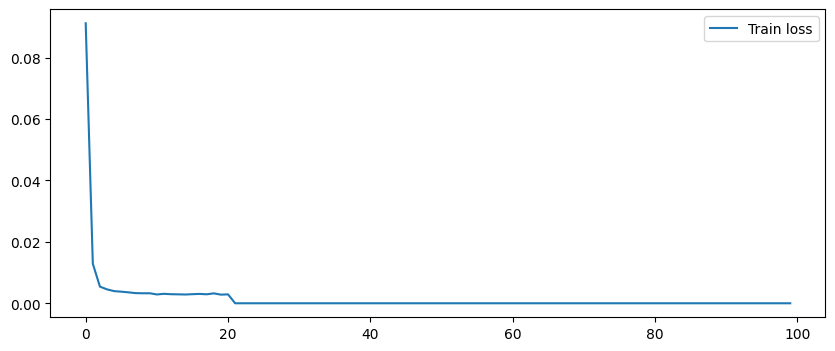

In [ ]:
#epoch별 손실값 확인
fig = plt.figure(figsize = (10,4))
plt.plot(train_hist, label='Train loss')
plt.legend()
plt.show()

In [ ]:
#예측 검증
model.to('cpu')
with torch.no_grad():
    pred = []

    for pr in range(len(testX_tensor)):
        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr],0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1,1))
    testY_inverse = scaler_y.inverse_transform(testY_tensor)

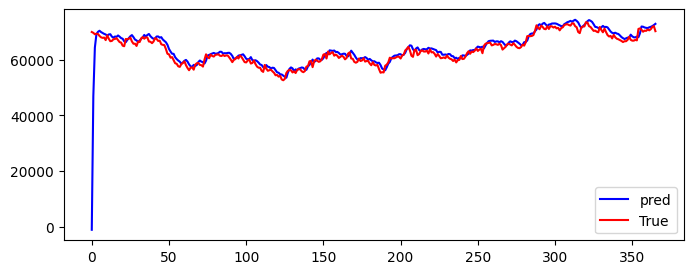

In [ ]:
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label ='pred' , color='b')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'True', color='r')
plt.legend()
plt.show()

In [ ]:
next(model.parameters()).get_device()

-1